In [1]:
import math
import os
import json
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [4]:
from torchvision import transforms
from PIL import Image
from diffusers import DDPMScheduler, PNDMScheduler
from diffusers.optimization import get_cosine_schedule_with_warmup
from diffusers import UNet2DConditionModel

In [5]:
from zizi_pipeline import *

from accelerate import Accelerator
from tqdm.auto import tqdm
from pathlib import Path

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

In [7]:
config = TrainingConfig(
    "data/pink-me/",
    "output/pink-256-unconditional/",
    image_size=256,
    train_batch_size=16,
    lr_warmup_steps=0,
    num_epochs=100,
    save_model_epochs=15,
    save_image_epochs=1,
    mixed_precision="no",
)

In [22]:
train_dataloader = get_dataloader(config)
model = get_unet_uncond(config).to("cuda")
optimizer = get_adamw(config, model)
lr_scheduler = get_const_lr(config, optimizer)

In [40]:
noise_scheduler = PNDMScheduler(
    beta_end=0.012,
    beta_start=0.00001,
    beta_schedule="scaled_linear",
    skip_prk_steps=True,
    steps_offset=0,
    set_alpha_to_one=False,
    prediction_type="v_prediction"
) #get_ddpm()

In [13]:
sample_image = train_dataloader.dataset[0]["images"].unsqueeze(0).to("cuda")

tensor([539], device='cuda:0')


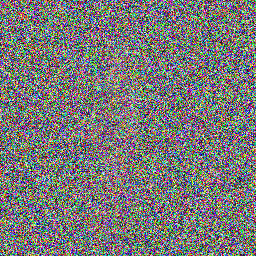

In [44]:
noise = torch.randn(sample_image.shape).to(sample_image.device)
timesteps = torch.randint(
    0,
    noise_scheduler.config.num_train_timesteps,
    (1,),
    device=sample_image.device,
).long()
print(timesteps)
noisy_image = noise_scheduler.add_noise(sample_image, noise, torch.tensor([500]).to("cuda"))

Image.fromarray(((noisy_image.cpu().permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

In [25]:
noise_pred = model(noisy_image, timesteps, return_dict=False)[0]

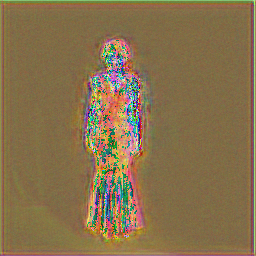

In [26]:
Image.fromarray(((noise_pred.cpu().permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

In [27]:
loss = F.mse_loss(noise_pred, noise)

In [28]:
loss

tensor(1.0696, device='cuda:0', grad_fn=<MseLossBackward0>)

In [17]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

In [18]:
def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i % cols * w, i // cols * h))
    return grid


def evaluate(config, epoch, pipeline, condition):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        condition,
        batch_size=config.eval_batch_size,
        generator=torch.manual_seed(config.seed),
        num_inference_steps=50
    ).images

    # Make a grid out of the images
    image_grid = make_grid(images, rows=2, cols=2)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

In [14]:
def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    if accelerator.is_main_process:
        os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_example")

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch["images"]
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device
            ).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            poses = batch["poses"].reshape((config.train_batch_size, 1, 75))

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, poses, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = ZiziPipeline(unet_conditional=accelerator.unwrap_model(model), scheduler=noise_scheduler).to(accelerator.device)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline, dataset[0]["poses"].unsqueeze(0).to(accelerator.device))

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                pipeline.save_pretrained(f"{config.output_dir}-{str(epoch)}")

In [15]:
from accelerate import notebook_launcher

args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:371: UserWarning: `log_with=tensorboard` was passed but no supported trackers are currently installed.
  warnings.warn(f"`log_with={log_with}` was passed but no supported trackers are currently installed.")


  0%|          | 0/894 [00:00<?, ?it/s]

KeyboardInterrupt: 